In [ ]:
import os
from google.colab import drive
from tqdm import tqdm

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

In [ ]:
dataSetPath = []
drive.mount('/content/drive')
for root, dirs, files in os.walk('/content/drive/MyDrive/Androids-Corpus-Extracted'):
  for file in files:
      file_path = os.path.join(root, file)
      dataSetPath.append(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, csv_path_list, transform=None):
        self.audio_frame = csv_path_list
        self.transform = transform
        self.cache = {}

    def __len__(self):
        return len(self.audio_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_path = self.audio_frame[idx]

        if audio_path in self.cache:
            audio_info, label = self.cache[audio_path]
        else:
            audio_label = audio_path.split('/')[-1].split('_')[1][0]
            audio_info = torch.from_numpy(np.asarray(pd.read_csv(audio_path)).astype('float'))
            if audio_label == 'C':
                label = 0
            elif audio_label == 'P':
                label = 1
            else:
                label = audio_label

            self.cache[audio_path] = (audio_info, label)

        sample = {'exaudio': audio_info, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
dataset = AudioDataset(csv_path_list = dataSetPath)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset,  batch_size=32, shuffle=False, collate_fn=None)
test_loader = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [ ]:
print(train_size,test_size)

788 198


# **Paper reproduction Part**
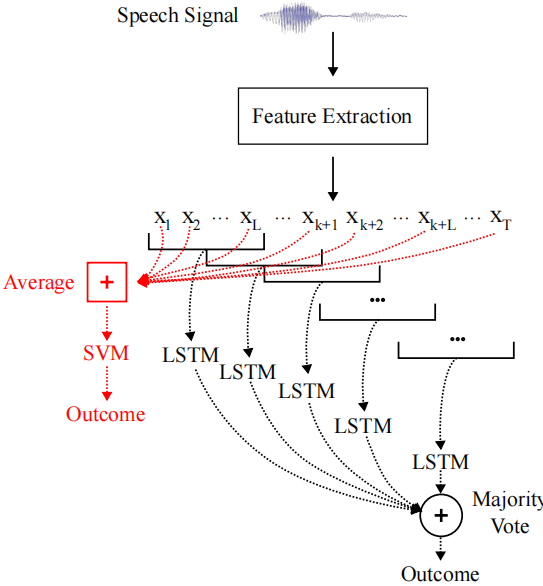

## **Support Vector Machine**
Calculating the average of the xk vectors and giving it as input to a Support Vector Machine with linear kernel.

In [ ]:
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
# 遍历训练集

for sample in tqdm(train_dataset):
    xk_mean = torch.mean(sample['exaudio'], dim=0)  # 计算特征的均值
    xk_mean_numpy = xk_mean.numpy().reshape(1, -1)  # 转换为 NumPy 数组并重塑形状
    label_numpy = np.array([sample['label']])  # 获取标签并转换为 NumPy 数组

    # 收集数据
    X_train.append(xk_mean_numpy)
    y_train.append(label_numpy)
# 遍历testset

for sample in tqdm(test_dataset):
    xk_mean = torch.mean(sample['exaudio'], dim=0)  # 计算特征的均值
    xk_mean_numpy = xk_mean.numpy().reshape(1, -1)  # 转换为 NumPy 数组并重塑形状
    label_numpy = np.array([sample['label']])  # 获取标签并转换为 NumPy 数组

    # 收集数据
    X_test.append(xk_mean_numpy)
    y_test.append(label_numpy)

# 将列表转换为 NumPy 数组
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

100%|██████████| 198/198 [00:50<00:00,  3.89it/s]


In [ ]:
# 训练 SVM 模型
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

**Evaluation**

Train Accuracy: 80.33%
Accuracy: 80.33%
Precision: 0.81
Recall: 0.59
F1 Score: 0.69
Test Accuracy: 75.76%
Accuracy: 75.76%
Precision: 0.78
Recall: 0.52
F1 Score: 0.62


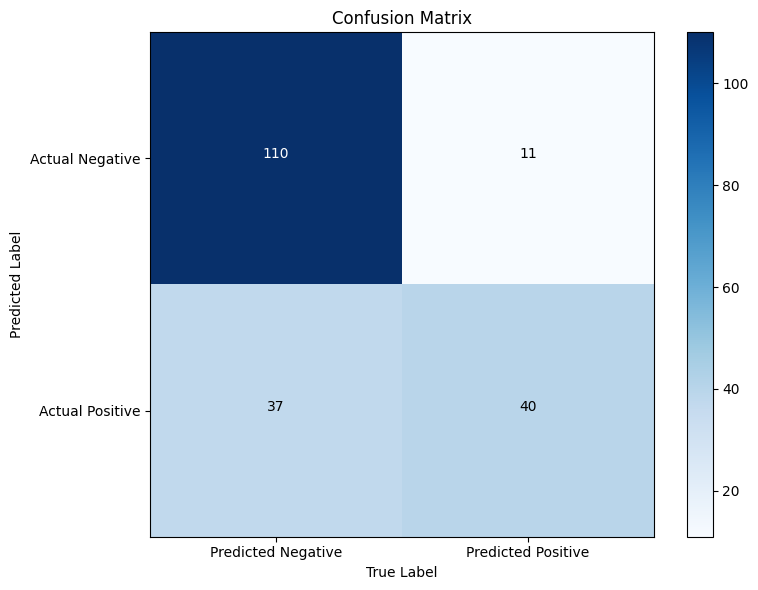

In [ ]:
y_pred_train = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
cm1 = confusion_matrix(y_train, y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

y_pred_test = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
cm2 = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], labels=['Actual Negative', 'Actual Positive'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

thresh = cm2.max() / 2.
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(j, i, format(cm2[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## LSTM

Segments the X into subsequences of length L = 128, the frames, that start at regular steps of length L/2 (two consecutive frames overlap by half of their vectors). Each frame is given as input individually to a Long Short-Term Memory Network (LSTM) and assigned to one of the two possible classes (depression and control). The LSTM has one hidden layer with 32 hidden states (both parameters were set a-priori). Given that there are multiple frames per recording, the individual frame classification outcomes are aggregated through a majority vote (the recording is assigned to the class its frames are most frequently assigned to).

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
# 参数设置
L = 128
step = L // 2
input_size = 32
hidden_size = 32
num_classes = 2
num_epochs = 100
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        print(out.shape)
        return out
model = LSTMClassifier(input_size, hidden_size, num_classes).to(device)
# Each parameter is typically 4 bytes (32 bits)
total_params = 0
for param in model.parameters():
    total_params += param.numel()
total_memory_MB = total_params * 4 / (1024 ** 2)

print(f"Total number of parameters: {total_params}")
print(f"Total memory required: {total_memory_MB:.4f} MB")

Total number of parameters: 8514
Total memory required: 0.0325 MB


In [ ]:
# 定义 LSTM 分类器
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        print(out.shape)
        return out

# 参数设置
L = 128
step = L // 2
input_size = 32
hidden_size = 32
num_classes = 2
num_epochs = 100
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 模型实例化
model = LSTMClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 数据预处理函数
def create_subsequences(data, L, step):
    # subsequences = []
    # for i in range(0, data.shape[0] - L + 1, step):
    #     subsequences.append(data[i:i + L,:])
    # return np.stack(subsequences, axis=0)
    subsequences = []
    if data.shape[0] < L:
        #print(f"Data length {data.shape[0]} is shorter than the subsequence length {L}. Skipping this sample.")
        # return np.array([])  # 返回空数组以表示无有效子序列
        return data.unsqueeze(0)
    for i in range(0, data.shape[0] - L + 1, step):
        subsequences.append(data[i:i + L, :])
    return np.stack(subsequences, axis=0)

loss_lis = []
# 训练模型
for epoch in tqdm(range(num_epochs)):
    model.train()
    ls = 0
    for i in range(len(train_dataset)):
      subsequences = create_subsequences(train_dataset[i]['exaudio'], L, step)
      inputs = torch.tensor(subsequences, dtype=torch.float32).to(device)
      labels = torch.tensor([train_dataset[i]['label']] * inputs.size(0), dtype=torch.long).to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      ls = ls + loss.item()
    train_loss = ls/len(train_dataset)
    loss_lis.append(ls/len(train_dataset))

    y_pred = []
    y_true = []
    ls = 0
    with torch.no_grad():
      for i in range(len(test_dataset)):
          subsequences = create_subsequences(test_dataset[i]['exaudio'], L, step)
          inputs = torch.tensor(subsequences, dtype=torch.float32).to(device)
          outputs = model(inputs)
          labels = torch.tensor([test_dataset[i]['label']] * inputs.size(0), dtype=torch.long).to(device)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs, 1)
          predicted = predicted.cpu().numpy()
          ls = ls + loss.item()
          # 多数投票机制
          most_common = Counter(predicted).most_common(1)[0][0]
          y_true.append(test_dataset[i]['label'])
          y_pred.append(most_common)
      accuracy = accuracy_score(y_true, y_pred)
      val_loss = ls/len(test_dataset)
      print('\n')
      print(f"Training Loss: {train_loss:.4f}")
      print(f"Validation Loss: {val_loss:.4f}")
      print(f"Validation Accuracy: {accuracy:.4f}")

# # 绘制损失曲线
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), loss_lis, marker='o', linestyle='-', color='b', label='Training Loss')
# plt.title('Training Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

# # 设置 x 轴刻度间隔
# plt.xticks(np.arange(1, num_epochs + 1, 10))  # 每隔 10 个 epoch 显示一个刻度
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([109, 2])
torch.Size([4, 2])
torch.Size([1, 2])


  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# 评估模型
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        subsequences = create_subsequences(test_dataset[i]['exaudio'], L, step)
        inputs = torch.tensor(subsequences, dtype=torch.float32).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

        # 多数投票机制
        most_common = Counter(predicted).most_common(1)[0][0]
        y_true.append(test_dataset[i]['label'])
        y_pred.append(most_common)

# 计算评估指标
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], labels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()